# Priority - the order of the route

Here we test whether the driver adhere the order of the route.
We also check the effect of subsequent orders

### Inputs:



In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import geopandas as gpd
import shapely
from geopy.distance import vincenty

In [28]:
#Helper functions
def get_sec_m_h(time_str):
    h, m, s = time_str.split(':')
    h, m, s = int(h), int(m), int(s)
    return (h * 3600 + m * 60 + s, h * 24 + m, h) 

def pandasVincenty(p1, p2):
    '''calculate distance (m) between two lat&long points using the Vincenty formula '''
    return vincenty((p1.x, p1.y), (p2.x, p2.y)).kilometers 

def getInventoryType(invList):
    exclusionList = [ 64.0, 58.0]
    for i in invList:
        if i not in exclusionList:
            return i
    return -1.0

# Defenitions of returned value:
# -1: The first task in the route - no option to check against the previous site
# 0:  Not in order
# 1:  In Order
def isInOrder(cur_opt_order, prev_opt_order, cur_act_order, prev_act_order):
    if (cur_act_order == 1 & cur_opt_order == 1):
        return 1
    if ((cur_opt_order == prev_opt_order + 1.0) & (cur_act_order == prev_act_order + 1.0)):
        return 1
    return 0

In [29]:
csv_results = 'https://prod-eu1-redash.bringg.com/api/queries/413/results.csv?api_key=8PwUxOmyYdXPQNixs7M2QzzU4SRvGoKHSrfUlCcO'
df_raw = pd.read_csv(csv_results)

print('Initial Length: ' + str(len(df_raw)))
# Drop incomplete data
df_raw.dropna(subset=['act_in', 'opt_in', 'act_out', 'opt_out', 'task_id','run_id', 'act_order'], inplace=True)
print('After dropping nulls: ' + str(len(df_raw)))
df_raw['prev_task'] = df_raw.task_id.shift(1)
df_raw['prev_opt_order'] = df_raw.opt_order.shift(1)
df_raw.head()

Initial Length: 68257
After dropping nulls: 65031


,task_id,run_id,driver,team_id,t_date,act_order,opt_order,opt_in,act_in,opt_out,...,lat,lng,bringg_etos,tos,inventory_name,inventory_etos,cat_id,order_late,prev_task,prev_opt_order
0,3040439,42626.0,371.0,20,2018-12-21,1,1,08:26:00,08:38:34,08:51:00,...,50.614661,3.001757,25,2.864949,SAV D�pose de pr�t SAV pour Solvarea BOULANGER,NaN,NaN,False,NaN,NaN
1,3040440,42626.0,371.0,20,2018-12-21,2,2,08:59:00,09:06:41,09:49:00,...,50.632220,3.069406,50,5.080749,BDOM TV Samsung Smart-Interaction 1h L BDOM,NaN,NaN,False,3040439.0,1.0
2,3040440,42626.0,371.0,20,2018-12-21,3,2,08:59:00,09:06:41,09:49:00,...,50.632220,3.069406,50,5.080749,TV SAMSUNG QE65Q7F 2018 SAMSUNG,25.0,62.0,False,3040440.0,2.0
3,3040449,42626.0,371.0,20,2018-12-21,4,3,09:56:00,09:29:42,10:16:00,...,50.673658,3.070168,20,19.750263,LL Front HISENSE EX WFEH9014VA HISENSE,15.0,5.0,False,3040440.0,2.0
4,3040449,42626.0,371.0,20,2018-12-21,5,3,09:56:00,09:29:42,10:16:00,...,50.673658,3.070168,20,19.750263,Reprise DEEE,15.0,58.0,False,3040449.0,3.0


In [30]:
groups = df_raw.groupby(['task_id','run_id', 't_date'])
df_tasks = pd.DataFrame({'task_id': groups.task_id.max(),   
                         'run': groups.run_id.min(),              'date': groups.t_date.min(),             
                         'max_prev_task': groups.prev_task.max(), 'min_prev_task': groups.prev_task.min(),    
                         'opt_order':groups.opt_order.max(),      'prev_opt_order':groups.prev_opt_order.min(),
                         'min_act_order': groups.act_order.min(), 'max_act_order': groups.act_order.max(), 
                         'inv_count': groups.size(),
                         'tos': groups.tos.mean(),                'calc_tos': groups.bringg_etos.mean(),
                         'opt_in': groups.opt_in.min(),           'opt_out':groups.opt_out.max(),
                         'act_in': groups.act_in.min(),           'act_out':groups.act_out.max(),
                         'team': groups.team_id.min(),            'driver': groups.driver.max(),
                         'is_late': groups.order_late.max(),      'name':groups.inventory_name.min()
                      })
df_tasks['prev_task'] = np.where(df_tasks['task_id'] == df_tasks['min_prev_task'], df_tasks['max_prev_task'], df_tasks['min_prev_task'])
df_tasks.drop(['max_prev_task', 'min_prev_task'], inplace=True, axis=1)

In [31]:
df_tasks['prev_act_order'] = df_tasks[1:].apply(lambda r: df_tasks[df_tasks['task_id'] == r.prev_task].max_act_order.max(), axis=1)

df_tasks['isInOrder'] = df_tasks.apply(lambda r: isInOrder(r.opt_order, r.prev_opt_order, r.min_act_order, r.prev_act_order), axis=1)

df_tasks['prev_act_out'] = df_tasks[df_tasks['isInOrder'] == 1].apply(lambda r: df_tasks[df_tasks['task_id'] == r.prev_task].act_out.max(), axis=1)
df_tasks['prev_opt_out'] = df_tasks[df_tasks['isInOrder'] == 1].apply(lambda r: df_tasks[df_tasks['task_id'] == r.prev_task].opt_out.max(), axis=1)

df_tasks.sort_values(['date','run_id', 'opt_order'], inplace=True)
df_tasks[df_tasks['run'] == 42626.0].head(100)

,,,task_id,run,date,opt_order,prev_opt_order,min_act_order,max_act_order,inv_count,tos,calc_tos,...,act_out,team,driver,is_late,name,prev_task,prev_act_order,isInOrder,prev_act_out,prev_opt_out
task_id,run_id,t_date,,,,,,,,,,,,,,,,,,,,,
3040439,42626.0,2018-12-21,3040439,42626.0,2018-12-21,1,NaN,1,1,1,2.864949,25,...,08:41:26,20,371.0,False,SAV D�pose de pr�t SAV pour Solvarea BOULANGER,NaN,NaN,1,NaN,NaN
3040440,42626.0,2018-12-21,3040440,42626.0,2018-12-21,2,1.0,2,3,2,5.080749,50,...,09:11:45,20,371.0,False,BDOM TV Samsung Smart-Interaction 1h L BDOM,3040439.0,1.0,1,08:41:26,08:51:00
3040449,42626.0,2018-12-21,3040449,42626.0,2018-12-21,3,2.0,4,6,3,19.750263,20,...,09:49:27,20,371.0,False,LL Front HISENSE EX WFEH9014VA HISENSE,3040440.0,3.0,1,09:11:45,09:49:00
3040435,42626.0,2018-12-21,3040435,42626.0,2018-12-21,4,3.0,7,10,4,5.273919,65,...,10:13:56,20,371.0,False,Four Pyro ELECTROLUX EOC5741BOX/1 ELECTROLUX,3040449.0,6.0,1,09:49:27,10:16:00
3040438,42626.0,2018-12-21,3040438,42626.0,2018-12-21,5,4.0,11,11,1,12.074857,15,...,10:36:06,20,371.0,False,Combi SAMSUNG RB29HSR3DWW/ SAMSUNG,3040435.0,10.0,1,10:13:56,11:28:00
3040434,42626.0,2018-12-21,3040434,42626.0,2018-12-21,6,5.0,12,14,3,27.069884,25,...,11:23:10,20,371.0,False,Cuisini�re BRANDT BCM6655W BRANDT,3040438.0,11.0,1,10:36:06,11:48:00
3040442,42626.0,2018-12-21,3040442,42626.0,2018-12-21,8,6.0,15,17,3,112.126120,15,...,13:30:31,20,371.0,False,Reprise DEEE,3040434.0,14.0,0,NaN,NaN
3040428,42626.0,2018-12-21,3040428,42626.0,2018-12-21,9,8.0,18,20,3,0.148915,20,...,13:30:47,20,371.0,False,LL Front ESSENTIELB ELF 814DD4 ESSENTIELB,3040442.0,17.0,1,13:30:31,13:42:00


In [32]:
print(len(df_tasks))

print(df_tasks.isInOrder.value_counts())
print(len(df_tasks.run.unique()))

25234
1    20147
0     5087
Name: isInOrder, dtype: int64
1473


In [38]:
print('Initial Length: ' + str(len(df_tasks)))
# Drop incomplete data
df_tasks.dropna(subset=['opt_in', 'act_in', 'act_out', 'opt_out'], inplace=True)
print('After dropping nulls: ' + str(len(df_tasks)))

df_tasks['tbs_opt'] = df_tasks[(df_tasks['isInOrder'] == 1) & (df_tasks['min_act_order'] > 1)].apply(lambda row: (get_sec_m_h(row.opt_in)[0] - get_sec_m_h(row.prev_opt_out)[0])/60, axis=1)
df_tasks['tbs_act'] = df_tasks[(df_tasks['isInOrder'] == 1) & (df_tasks['min_act_order'] > 1)].apply(lambda row: (get_sec_m_h(row.act_in)[0] - get_sec_m_h(row.prev_act_out)[0])/60, axis=1)
#df_tasks['geo'] = [shapely.geometry.Point(xy) for xy in zip(df.lng, df.lat)]
#df['prev_loc'] = df['geo'].shift(1)
#df['distance'] = df[1:].apply(lambda r: pandasVincenty(r.geo, r.prev_loc), axis=1)

df_tbs = pd.DataFrame(df_tasks[df_tasks['isInOrder'] == 1])

Initial Length: 25234
After dropping nulls: 25234


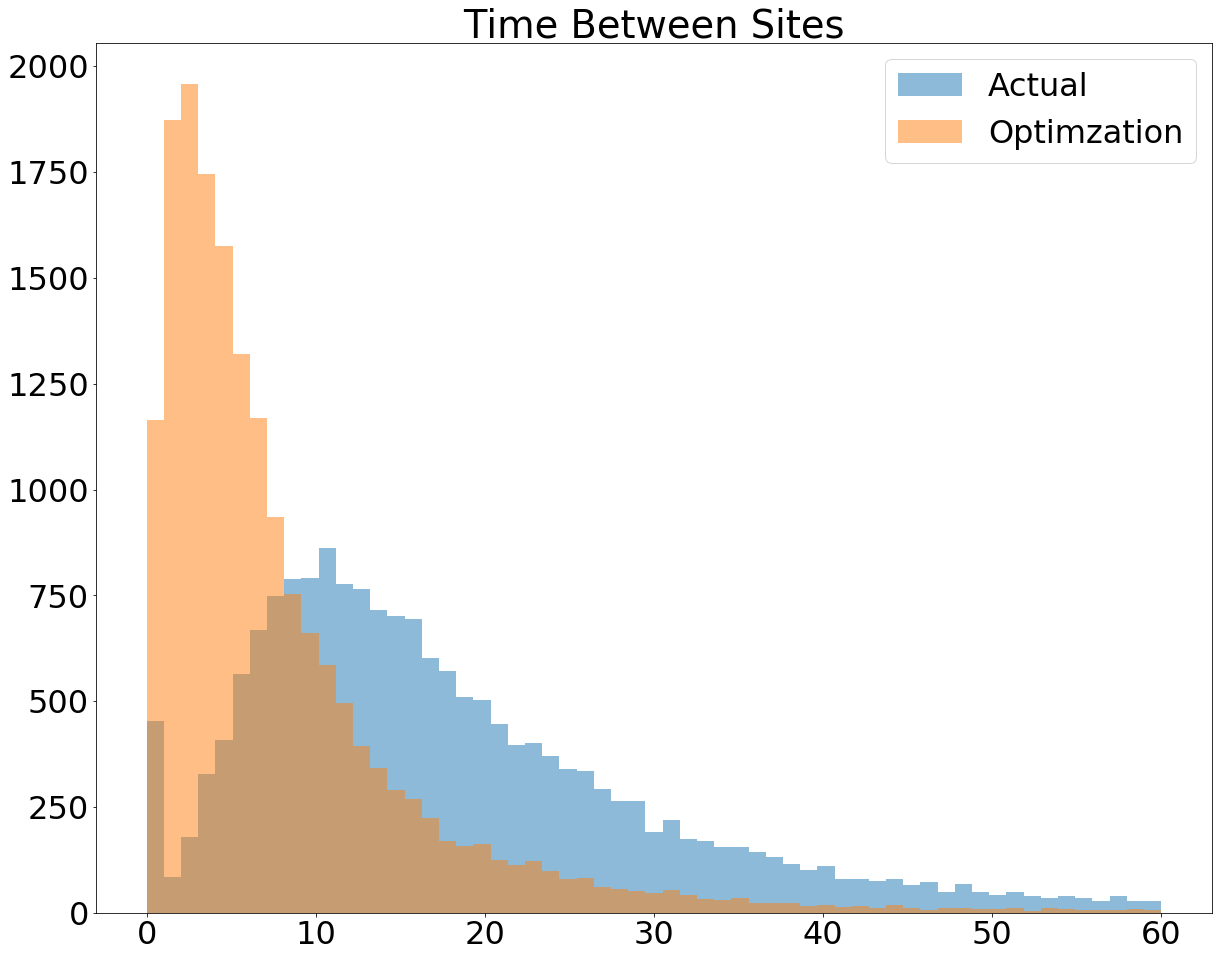

In [42]:
from matplotlib import pyplot
bins = np.linspace(0, 60, 60)
pyplot.hist(df_tbs[df_tbs['tbs_act'] > 0].tbs_act, bins, alpha=0.5, label='Actual')
pyplot.hist(df_tbs[df_tbs['tbs_act'] > 0].tbs_opt, bins, alpha=0.5, label='Optimzation')
pyplot.legend(loc='upper right')
pyplot.title('Time Between Sites')
pyplot.rcParams["figure.figsize"] = (20,16)
pyplot.rcParams.update({'font.size': 32})
pyplot.show()

In [71]:
groups = df_tasks.groupby('t_date')
df_date = pd.DataFrame({'date': groups.date.min(),
                        'order_count': groups.size(), 'runs': groups.run.nunique(),'driver': groups.driver.nunique(),
                        'late': groups.is_late.sum(), 'inOrder': groups.isInOrder.sum(), 
                        'tbs_opt': groups.tbs_opt.sum(), 'tbs_act': groups.tbs_act.sum(),
                       'mean_tbs_opt': groups.tbs_opt.mean(), 'mean_tbs_act': groups.tbs_act.mean(),
                       })
df_date.corr()

,order_count,runs,driver,late,inOrder,tbs_opt,tbs_act,mean_tbs_opt,mean_tbs_act
order_count,1.000000,0.988702,0.989431,0.673479,0.996344,0.362036,0.987098,-0.156931,-0.299578
runs,0.988702,1.000000,0.995878,0.659553,0.984347,0.371330,0.983223,-0.145210,-0.282583
driver,0.989431,0.995878,1.000000,0.668677,0.981629,0.363542,0.978800,-0.151504,-0.285893
late,0.673479,0.659553,0.668677,1.000000,0.626897,0.235611,0.636859,-0.088235,-0.150126
inOrder,0.996344,0.984347,0.981629,0.626897,1.000000,0.378732,0.987740,-0.140500,-0.307710
tbs_opt,0.362036,0.371330,0.363542,0.235611,0.378732,1.000000,0.349368,0.852534,-0.161762
tbs_act,0.987098,0.983223,0.978800,0.636859,0.987740,0.349368,1.000000,-0.165890,-0.240430
mean_tbs_opt,-0.156931,-0.145210,-0.151504,-0.088235,-0.140500,0.852534,-0.165890,1.000000,0.047824
mean_tbs_act,-0.299578,-0.282583,-0.285893,-0.150126,-0.307710,-0.161762,-0.240430,0.047824,1.000000


In [72]:
df_date.head()

,date,order_count,runs,driver,late,inOrder,tbs_opt,tbs_act,mean_tbs_opt,mean_tbs_act
t_date,,,,,,,,,,
2018-11-30,2018-11-30,832,105,101,142.0,588,4011.083333,10259.183333,7.483364,19.140267
2018-12-01,2018-12-01,1296,136,117,136.0,1042,5295.016667,18121.616667,5.645007,19.319421
2018-12-02,2018-12-02,65,7,5,5.0,52,265.233333,792.783333,5.525694,16.516319
2018-12-03,2018-12-03,1160,113,101,192.0,872,5872.200000,14678.300000,7.490051,18.722321
2018-12-04,2018-12-04,881,95,85,87.0,719,5761.716667,12681.100000,8.960679,19.721773


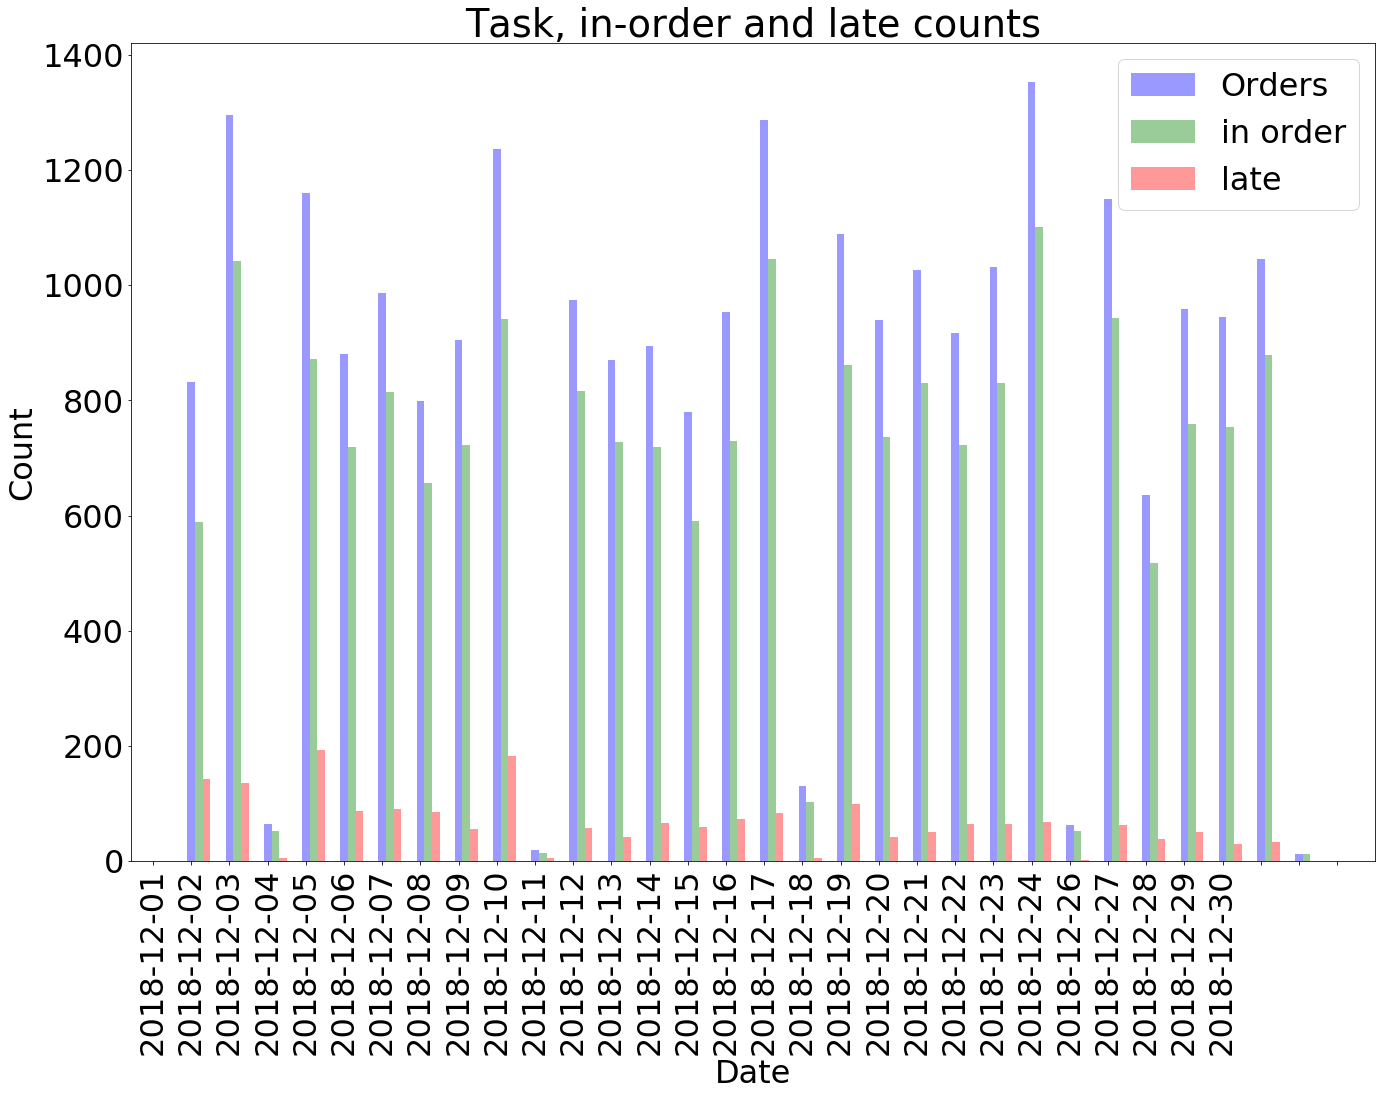

In [99]:
#https://matplotlib.org/gallery/statistics/barchart_demo.html
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import namedtuple

n_groups = len(df_date)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.2

opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, df_date.order_count, bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
               label='Orders')

rects2 = ax.bar(index  + bar_width, df_date.inOrder, bar_width,
                alpha=opacity, color='g',
                error_kw=error_config,
                label='in order')

rects3 = ax.bar(index  + 2 * bar_width, df_date.late, bar_width,
                alpha=opacity, color='r',
                error_kw=error_config,
                label='late')

ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Task, in-order and late counts')

ax.set_xticklabels(df_date.date,rotation=90)
#ax.set_xticks(index + bar_width / 2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend()

fig.tight_layout()
plt.show()